Computing rolling stats: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ static_input        │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_input           │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        288 │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     33,792 │ seq_input[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_vol (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,449 (173.63 KB)

 Trainable params: 44,449 (173.63 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2602/2602 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
R² (log-space): 0.8671
MSE (vol): 24928432874638.9
MAE (vol): 1213371.3
R²  (vol): 0.8301
Baseline R² (vol): 0.6418


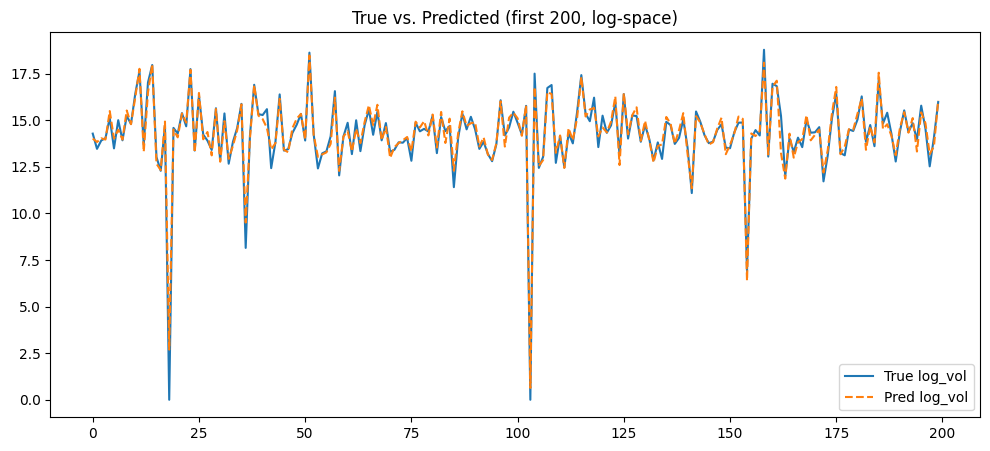

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm.keras import TqdmCallback

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, Dense, Dropout, concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import LambdaCallback

# 1) LOAD & SORT
df = pd.read_parquet('data/volume_pred.parquet')
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# 2) LOG TARGET
df['log_vol'] = np.log1p(df['VOL'])

# 3) LAG FEATURES (10-day window)
window = 10
for lag in tqdm(range(1, window+1), desc='Creating lag features'):
    df[f'lag_{lag}'] = df.groupby('ticker')['log_vol'].shift(lag)

# 4) CALENDAR FEATURES
df['weekday']        = df['date'].dt.weekday
df['month']          = df['date'].dt.month
df['is_month_end']   = df['date'].dt.is_month_end.astype(int)
df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)

# 5) ROLLING VOLUME STATS (shifted by 1 day)
roll_specs = [
    ('vol_ma_7',  7,  'mean'),
    ('vol_ma_21', 21, 'mean'),
    ('vol_std_7', 7,  'std'),
    ('vol_std_21',21, 'std')
]
for col_name, sz, func in tqdm(roll_specs, desc='Computing rolling stats'):
    grp = df.groupby('ticker')['VOL']
    if func == 'mean':
        df[col_name] = grp.rolling(sz).mean().shift(1).reset_index(level=0,drop=True)
    else:
        df[col_name] = grp.rolling(sz).std().shift(1).reset_index(level=0,drop=True)

# 6) DROP ANY ROWS WITH MISSING FEATURES
feat_cols = (
    [f'lag_{i}' for i in range(1,window+1)] +
    ['weekday','month','is_month_end','is_quarter_end',
     'vol_ma_7','vol_ma_21','vol_std_7','vol_std_21']
)
df.dropna(subset=feat_cols + ['log_vol'], inplace=True)
df.reset_index(drop=True, inplace=True)

# 7) BUILD ARRAYS
X_seq    = df[[f'lag_{i}' for i in range(1,window+1)]].values.reshape(-1, window, 1)
X_static = df[['weekday','month','is_month_end','is_quarter_end',
               'vol_ma_7','vol_ma_21','vol_std_7','vol_std_21']].values
y_log    = df['log_vol'].values

# 8) TRAIN/TEST SPLIT
X_seq_tr, X_seq_te, X_st_tr, X_st_te, y_tr_log, y_te_log = train_test_split(
    X_seq, X_static, y_log, test_size=0.2, random_state=42, shuffle=True
)

# 9) STANDARDIZE
scaler_static = StandardScaler().fit(X_st_tr)
X_st_tr = scaler_static.transform(X_st_tr)
X_st_te = scaler_static.transform(X_st_te)

scaler_y = StandardScaler().fit(y_tr_log.reshape(-1,1))
y_tr_s   = scaler_y.transform(y_tr_log.reshape(-1,1))
y_te_s   = scaler_y.transform(y_te_log.reshape(-1,1))

# 10) TF.DATASETS
batch_size = 32
train_ds = (tf.data.Dataset.from_tensor_slices(((X_seq_tr, X_st_tr), y_tr_s))
                .shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE))
val_ds   = (tf.data.Dataset.from_tensor_slices(((X_seq_te, X_st_te), y_te_s))
                .batch(batch_size).prefetch(tf.data.AUTOTUNE))

# 11) MODEL DEFINITION
seq_in = Input(shape=(window,1), name='seq_input')
x      = Bidirectional(LSTM(64, return_sequences=True))(seq_in)
x      = Bidirectional(LSTM(64))(x)

st_in = Input(shape=(X_st_tr.shape[1],), name='static_input')
s      = Dense(32, activation='relu')(st_in)
s      = Dropout(0.2)(s)

m = concatenate([x, s])
m = Dense(64, activation='relu')(m)
m = Dropout(0.2)(m)
out = Dense(1, name='log_vol')(m)

model = Model([seq_in, st_in], out)
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model.summary()

# 12) TRAIN with tqdm callback
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
EPOCHS = 40
print_epoch_cb = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f"\nStarting epoch {epoch+1}/{EPOCHS}")
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[es, TqdmCallback(verbose=1)],
    verbose=0
)

# 13) PREDICTIONS & INVERT SCALING
y_pred_s   = model.predict(val_ds).flatten()
y_pred_log = scaler_y.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
y_base_log = X_seq_te[:,-1,0]  # persistence baseline

# 14) EVALUATION
def evaluate(y_true_log, y_pred_log, y_base_log):
    print(f"R² (log-space): {r2_score(y_true_log, y_pred_log):.4f}")
    y_true_vol = np.expm1(y_true_log)
    y_pred_vol = np.expm1(y_pred_log)
    y_base_vol = np.expm1(y_base_log)
    print(f"MSE (vol): {mean_squared_error(y_true_vol, y_pred_vol):.1f}")
    print(f"MAE (vol): {mean_absolute_error(y_true_vol, y_pred_vol):.1f}")
    print(f"R²  (vol): {r2_score(y_true_vol, y_pred_vol):.4f}")
    print(f"Baseline R² (vol): {r2_score(y_true_vol, y_base_vol):.4f}")

evaluate(y_te_log, y_pred_log, y_base_log)

# 15) PLOT FIRST 200 (log-space)
plt.figure(figsize=(12,5))
plt.plot(y_te_log[:200],    label='True log_vol')
plt.plot(y_pred_log[:200], '--', label='Pred log_vol')
plt.legend()
plt.title("True vs. Predicted (first 200, log-space)")
plt.show()